In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [3]:
class Normalizer():

    def fit_trnsform(self, X):
        self.min = X.min()
        self.max = X.max()
        self.vrange = (self.max - self.min)
        return (X - self.min) / self.vrange
    
    def denormalize(self, X):
        return (X * self.vrange) + self.min

normalizer = Normalizer()

In [4]:
def create_nn_dataset(data, w):
    data = normalizer.fit_trnsform(data)

    X = np.array([data[n: n+30] for n in range(data.shape[0]-29-w)])
    y = np.array([data[n: n+w] for n in range(30, data.shape[0]-w+1)])

    X_train, X_test, y_train, y_test = train_test_split(X[:-10], y[:-10], test_size=0.2)
    X_test = np.append(X_test, X[-10:], axis=0)
    y_test = np.append(y_test, y[-10:], axis=0)

    return X_train, X_test, y_train, y_test

In [5]:
df_litecoin = pd.read_csv('drive/MyDrive/NNDL/extra/Litecoin Historical Data.csv')
df_litecoin.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 09, 2023",79.28,77.78,79.78,77.31,769.16K,1.93%
1,"May 08, 2023",77.78,83.44,85.17,75.86,1.09M,-6.78%
2,"May 07, 2023",83.44,83.25,84.66,82.98,405.45K,0.23%
3,"May 06, 2023",83.25,88.61,89.24,81.01,808.79K,-6.05%
4,"May 05, 2023",88.61,88.37,89.64,86.75,462.78K,0.27%


In [6]:
def preprocess_and_get_datasets(df):
    vol_dict = {'K': '*1e3', 'M': '*1e6'}
    df['Vol.'] = df['Vol.'].replace(vol_dict, regex=True).map(pd.eval)
    X = df['Price'][::-1].to_numpy(dtype=np.float32)
    return create_nn_dataset(X, 7)

In [7]:
X_train, X_test, y_train, y_test_7d = preprocess_and_get_datasets(df_litecoin)
print(X_train.shape)
print(y_train.shape)

X_train.reshape((-1, 30, 1))
X_test.reshape((-1, 30, 1))

y_test_1d = y_test_7d[:, :1]
y_test_3d = y_test_7d[:, :3]
y_train = y_train[:, :1]

(1819, 30)
(1819, 7)


In [8]:
def build_proposed_model():
    # input layer
    input_layer = keras.layers.Input(shape=(30, 1))

    # LSTM block
    x = keras.layers.LSTM(30, return_sequences=True)(input_layer)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.LSTM(50)(x)
    lstm_output = keras.layers.Dense(10, activation="relu")(x)

    # GRU block
    x = keras.layers.GRU(30)(input_layer)
    x = keras.layers.Dropout(0.5)(x)
    gru_output = keras.layers.Dense(10, activation="relu")(x)

    # output layer
    x = keras.layers.Concatenate()([lstm_output, gru_output])
    output = keras.layers.Dense(1, activation="relu")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output)
    return model

proposed_model = build_proposed_model()
proposed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 30, 30)       3840        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 30)       0           ['lstm[0][0]']                   
                                                                                                  
 gru (GRU)                      (None, 30)           2970        ['input_1[0][0]']                
                                                                                              

In [9]:
def build_comparison_model():
    # input layer
    input_layer = keras.layers.Input(shape=(30, 1))

    # LSTM block
    x = keras.layers.LSTM(50)(input_layer)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation="relu")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output)
    return model

comparison_model = build_comparison_model()
comparison_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [10]:
def compile_and_train_model(model, lr=0.005, batch_size=32, epochs=100):

    # learning rate scheduler
    steps_per_epoch = np.ceil(X_train.shape[0] / batch_size).astype(int)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(lr,
        decay_steps=steps_per_epoch, decay_rate=0.75, staircase=True)

    # loss function and optimizer
    mse = keras.losses.MeanSquaredError()
    adam = keras.optimizers.Adam(learning_rate=lr_schedule)

    # compile model
    model.compile(optimizer=adam, loss=mse, metrics=['mse', 'mae'])

    # train model
    history = model.fit (
        X_train, y_train, 
        batch_size=batch_size, epochs=epochs)

    return history

In [11]:
history_1 = compile_and_train_model(proposed_model)

Epoch 1/100
57/57 [==============================] - 14s 32ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0431
Epoch 2/100
57/57 [==============================] - 3s 56ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0243
Epoch 3/100
57/57 [==============================] - 3s 60ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0219
Epoch 4/100
57/57 [==============================] - 3s 45ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0197
Epoch 5/100
57/57 [==============================] - 2s 30ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0190
Epoch 6/100
57/57 [==============================] - 2s 31ms/step - loss: 9.4246e-04 - mse: 9.4246e-04 - mae: 0.0188
Epoch 7/100
57/57 [==============================] - 2s 35ms/step - loss: 8.8984e-04 - mse: 8.8984e-04 - mae: 0.0185
Epoch 8/100
57/57 [==============================] - 2s 30ms/step - loss: 8.7581e-04 - mse: 8.7581e-04 - mae: 0.0179
Epoch 9/100
57/57 [==============================] - 2s 30ms/step - loss: 8.5609e-04 - mse: 8.5609e-04 

In [12]:
history_2 = compile_and_train_model(comparison_model)

Epoch 1/100
57/57 [==============================] - 3s 13ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0557
Epoch 2/100
57/57 [==============================] - 1s 11ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0319
Epoch 3/100
57/57 [==============================] - 1s 18ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0289
Epoch 4/100
57/57 [==============================] - 1s 18ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0264
Epoch 5/100
57/57 [==============================] - 1s 12ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0253
Epoch 6/100
57/57 [==============================] - 1s 12ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0235
Epoch 7/100
57/57 [==============================] - 1s 12ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0239
Epoch 8/100
57/57 [==============================] - 1s 12ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0225
Epoch 9/100
57/57 [==============================] - 1s 13ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0234
Epoch 10/100
57/57 

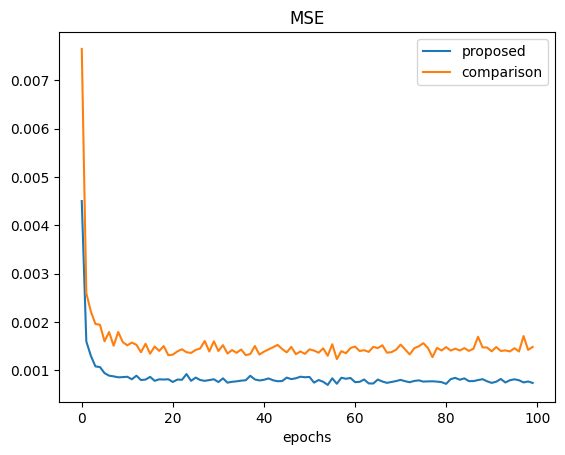

In [13]:
plt.plot(history_1.history['mse'], label='proposed')
plt.plot(history_2.history['mse'], label='comparison')
plt.legend()
plt.xlabel('epochs')
plt.title('MSE')
plt.show()

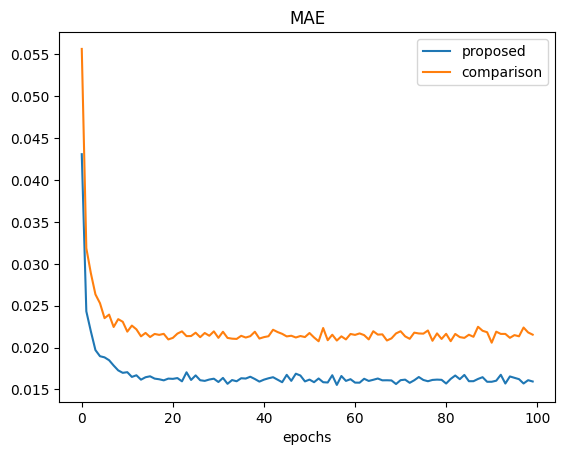

In [14]:
plt.plot(history_1.history['mae'], label='proposed')
plt.plot(history_2.history['mae'], label='comparison')
plt.legend()
plt.xlabel('epochs')
plt.title('MAE')
plt.show()

In [15]:
def predict(model, X_test, w):
    yp = []
    for i in range(w):
        yp_tmp = model.predict(X_test, verbose=0)
        yp.append(yp_tmp)
        if i < w - 1:
            X_test = np.concatenate([X_test[:, 1:], yp_tmp], axis=1)

    return np.concatenate(yp, axis=1)

In [16]:
def compute_metrics(y_test, w):

    yp_proposed = predict(proposed_model, X_test, w)
    yp_proposed = normalizer.denormalize(yp_proposed)

    yp_comparison = predict(comparison_model, X_test, w)
    yp_comparison = normalizer.denormalize(yp_comparison)

    y = normalizer.denormalize(y_test)

    mse_proposed = np.average((yp_proposed - y)**2)
    mse_comparison = np.average((yp_comparison - y)**2)

    rmse_proposed = np.sqrt(mse_proposed)
    rmse_comparison = np.sqrt(mse_comparison)

    mae_proposed = np.average(np.abs(yp_proposed - y))
    mae_comparison = np.average(np.abs(yp_comparison - y))

    mape_proposed = np.average(np.abs((yp_proposed - y) / y))
    mape_comparison = np.average(np.abs((yp_comparison - y) / y))

    print('model name\tMSE\t\tRMSE\t\tMAE\t\tMAPE')
    print(f'proposed\t{mse_proposed:.2f}\t\t{rmse_proposed:.2f}\t\t{mae_proposed:.2f}\t\t{mape_proposed:.2f}')
    print(f'comparison\t{mse_comparison:.2f}\t\t{rmse_comparison:.2f}\t\t{mae_comparison:.2f}\t\t{mape_comparison:.2f}')

In [17]:
compute_metrics(y_test_1d, 1)

model name	MSE		RMSE		MAE		MAPE
proposed	72.62		8.52		5.04		0.06
comparison	82.33		9.07		5.37		0.06


In [18]:
compute_metrics(y_test_3d, 3)

model name	MSE		RMSE		MAE		MAPE
proposed	146.86		12.12		6.37		0.07
comparison	144.43		12.02		6.43		0.07


In [19]:
compute_metrics(y_test_7d, 7)

model name	MSE		RMSE		MAE		MAPE
proposed	265.06		16.28		8.71		0.09
comparison	256.08		16.00		8.68		0.09
